# Notebook 8 - Extracting Boreholes and Depth Maps from GemPy Models

[GemGIS](https://github.com/cgre-aachen/gemgis) is a package for geographic information processing for geomodeling. In particular, data is prepared for direct use in [GemPy](https://github.com/cgre-aachen/gempy) via a GemPy Data Class. The package provides functions to process spatial data such as vector data (shape files, geojson files, geopackages), raster data (tiff-files), data retrieved from WMS Services or KML/XML files. 

At a later stage, functionality will be added to interactively add interfaces and orientations for a model, choosing the extent, defining custom sections and more. In addition, functionality will be provided to export data from GemPy into Geoinformation Systems such as QGIS or ArcGIS and Google Earth. 

# Overview

This notebook will present how virtual/synthtic boreholes and depth maps can be extracted from a [GemPy](https://github.com/cgre-aachen/gempy) model. 

- [What are Interfaces and Orientations?](#intandor)
- [What is GemPy?](#gempy)
- [Downloading and Installing GemGIS](#gemgis)
- [Structure of GemGIS](#structure)
- [Importing Libraries](#import)
- [Version Reports](#vreport)

- [Create GemPy Model](#model)
- [Extract Borehole](#borehole)
- [Extract Depth Maps](#map)


<a id='intandor'></a>
## What are Interfaces and Orientations?
`GemPy`uses an implicit modeling approach based on the potential field method to create geological models. The only input data required are interfaces (layer boundaries in outcrops or in wells) and orientations (dip and azimuth values of a given orientation). The necessary information for interfaces are the `X`,`Y` and `Z`coordinates as well as the `formation`. Please be aware that `GemPy` is always referring to the base of a formation! For orientations, `X`,`Y` and `Z`coordinates, the `formation` and `dip`, `azimuth` and a `polarity` values is needed. The polarity is usually set to 1. 

Strike, in geology, is the direction of the line formed by the intersection of a fault, bed, or other planar feature and a horizontal plane. Strike indicates the dip orientation or position of linear structural features such as faults, beds, joints, and folds.

<img src="../data/Images/orientations.jpg" width="500">

Source: https://www.britannica.com/science/strike-geology <br>
Image from: Geological Structures: a Practical Introduction -  John W.F. Waldron and Morgan Snyder 


<a id='gempy'></a>
## What is GemPy?

`GemPy` is a Python-based, **open-source geomodeling library**. It is
capable of constructing complex **3D geological models** of folded
structures, fault networks and unconformities, based on the underlying
powerful **implicit representation** approach. `GemPy` was designed from the
ground up to support easy embedding in probabilistic frameworks for the
uncertainty analysis of subsurface structures.

Check out the documentation either on the main website (https://www.gempy.org/) or the specific docs site (http://docs.gempy.org/).

- GemPy Installation Help: https://docs.gempy.org/installation.html
- GemPy Tutorials: https://docs.gempy.org/tutorials/index.html
- GemPy Examples: https://docs.gempy.org/examples/index.html
- GemPy Repository: https://github.com/cgre-aachen/gempy
- GemPy Tutorial Video: https://youtu.be/n0btC5Zilyc




<a id='gemgis'></a>
## Downloading and installing GemGIS

`GemGIS` is currently under development and only available at https://github.com/cgre-aachen/gemgis. pip and conda versions including a documentations page will follow.

<a id='structure'></a>
## Structure of GemGIS

The core of `GemGIS` is made of the `GemPyData` class (`gemgis.py`). Its attributes can directly be utilized by `GemPy` making it easier for users to load data. Methods of the `GemPyData` class allow users to directly set these attributes. Multiple other files contain functions to manipulate vector data, raster data, etc.:

* `gemgis.py` - core file containing the `GemPyData` class
* `vector.py` - file containing functions to manipulate vector data
* `raster.py` - file containing functions to manipulate raster data
* `utils.py` - file containing utility functions frequently used for the manipulation of vector/raster data
* `wms.py` - file containing methods to load WMS services as arrays/rasters
* `visualization.py` - file containing functions to simplify plotting of spatial data
* `postprocessing.py` - file containing functions to postprocess GemPy geo_model data
* `misc.py` - file containing functions for custom tasks 



If you have any problems using GemGIS, find a bug or have an idea for a new feature, open an issue at https://github.com/cgre-aachen/gemgis/issues. 

<a id='import'></a>
# Importing Libraries

Apart from creating a GemPyData class in later tutorials, GemGIS is working with pure GeoDataFrames, Rasterio files and NumPy arrays to provide the user with easy data handling. ***Currently, geopandas version 0.6.1 is the latest stable version that is supported by GemGIS***. A general introduction to working with rasters and Rasterio objects in GemGIS is provided in the working with raster files notebook.

In [1]:
import sys
sys.path.append('../../gemgis')
import gemgis as gg
import geopandas as gpd
import rasterio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
print(gg)

<module 'gemgis' from '../../gemgis\\gemgis\\__init__.py'>


<a id='vreport'></a>
# Version Reports
Reporting your Python environment's package versions and hardware resources by Scooby - https://github.com/banesullivan/scooby. This overview shows the packages and their versions used to run this notebook. Upgrading or downgrading to older or newer versions may break the notebook.

In [2]:
gg.Report()

--------------------------------------------------------------------------------
  Date: Sun Aug 02 11:31:08 2020 W. Europe Daylight Time

                OS : Windows
            CPU(s) : 24
           Machine : AMD64
      Architecture : 64bit
               RAM : 63.9 GB
       Environment : Jupyter

  Python 3.7.7 (default, May  6 2020, 11:45:54) [MSC v.1916 64 bit (AMD64)]

              json : 2.0.9
             numpy : 1.18.5
            scooby : 0.5.2
            owslib : 0.17.0
            pandas : 1.0.5
           shapely : 1.6.4.post1
           pyvista : 0.25.3
          rasterio : 1.0.21
         geopandas : 0.6.1
          requests : 2.24.0
             scipy : 1.5.0
        matplotlib : 3.2.2

  Intel(R) Math Kernel Library Version 2020.0.1 Product Build 20200208 for
  Intel(R) 64 architecture applications
--------------------------------------------------------------------------------

<a id='model'></a>
# Create GemPy Model

Before extracting boreholes, it is necessary to calculate the initial GemPy Model. Here, we will just use Example 1.

In [3]:
interfaces = gpd.read_file('../../gemgis/data/examples/example1/interfaces1_lines.shp')
orientations = gpd.read_file('../../gemgis/data/examples/example1/orientations1.shp')
extent = gpd.read_file('../../gemgis/data/examples/example1/extent1.shp')
geological_map = gpd.read_file('../../gemgis/data/examples/example1/geolmap1.shp')
topo = gpd.read_file('../../gemgis/data/examples/example1/topo1.shp')

In [4]:
geo_data = gg.GemPyData(model_name='Model1', crs='EPSG:4326')
geo_data.set_extent(gdf=extent, minz=300, maxz=800)
geo_data.set_resolution(50,50,50)
dem = gg.vector.interpolate_raster(topo, method='rbf')
interfaces_coords = gg.vector.extract_coordinates(interfaces,np.flipud(dem), extent=geo_data.extent)
geo_data.to_gempy_df(interfaces_coords, 'interfaces')
orientations_coords = gg.vector.extract_coordinates(orientations,np.flipud(dem),extent=geo_data.extent)
geo_data.to_gempy_df(orientations_coords, 'orientations')
geo_data.to_surface_color_dict('../../gemgis/data/examples/example1/style1.qml', basement='Sand2')
geo_data.stack = {"Strat_Series": ('Sand1', 'Ton')}

Please see https://docs.gempy.org/installation.html for more information on how to install GemPy.

In [5]:
import sys  
sys.path.append('../../gempy-master')
import gempy as gp
print(gp)
print(gp.__version__)

<module 'gempy' from '../../gempy-master\\gempy\\__init__.py'>
2.2.2


For more information on how to create a GemPy Model, please see the tutorials at: https://docs.gempy.org/tutorials/index.html. With the attributes of the GemPy Data Class, all necessary variables can be passed to the model.

In [6]:
geo_model = gp.create_model(geo_data.model_name)
gp.init_data(geo_model, geo_data.extent, geo_data.resolution,
             surface_points_df = geo_data.interfaces,
             orientations_df = geo_data.orientations,
             default_values=True)
geo_model.surfaces

Active grids: ['regular']


,surface,series,order_surfaces,color,id
0,Sand1,Default series,1,#015482,1
1,Ton,Default series,2,#9f0052,2


In [7]:
gp.map_stack_to_surfaces(geo_model,
                         geo_data.stack,
                         remove_unused_series=True)
geo_model.add_surfaces('basement')
geo_model.surfaces.colors.change_colors(geo_data.surface_colors)

,surface,series,order_surfaces,color,id
0,Sand1,Strat_Series,1,#b35a2a,1
1,Ton,Strat_Series,2,#525252,2
2,basement,Strat_Series,3,#b35a2a,3


A raster created with ArcGIS has to be loaded as the import of the created raster fails. This is due to a bug in `GemPy`described here: https://github.com/cgre-aachen/gempy/issues/492

In [8]:
geo_model.set_topography(
    source='gdal', filepath='../../gemgis/data/Test1/raster1.tif')

Cropped raster to geo_model.grid.extent.
depending on the size of the raster, this can take a while...
storing converted file...
Active grids: ['regular' 'topography']


Grid Object. Values: 
array([[   9.72      ,   10.69      ,  305.        ],
       [   9.72      ,   10.69      ,  315.        ],
       [   9.72      ,   10.69      ,  325.        ],
       ...,
       [ 970.056     , 1059.28181818,  622.0892334 ],
       [ 970.056     , 1063.16909091,  622.06713867],
       [ 970.056     , 1067.05636364,  622.05786133]])

In [9]:
gp.set_interpolator(geo_model,
                    compile_theano=True,
                    theano_optimizer='fast_compile',
                    verbose=[],
                    update_kriging = False
                    )

Compiling theano function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                   values
range             1528.9
$C_o$            55655.8
drift equations      [3]


In [10]:
sol = gp.compute_model(geo_model, compute_mesh=True)

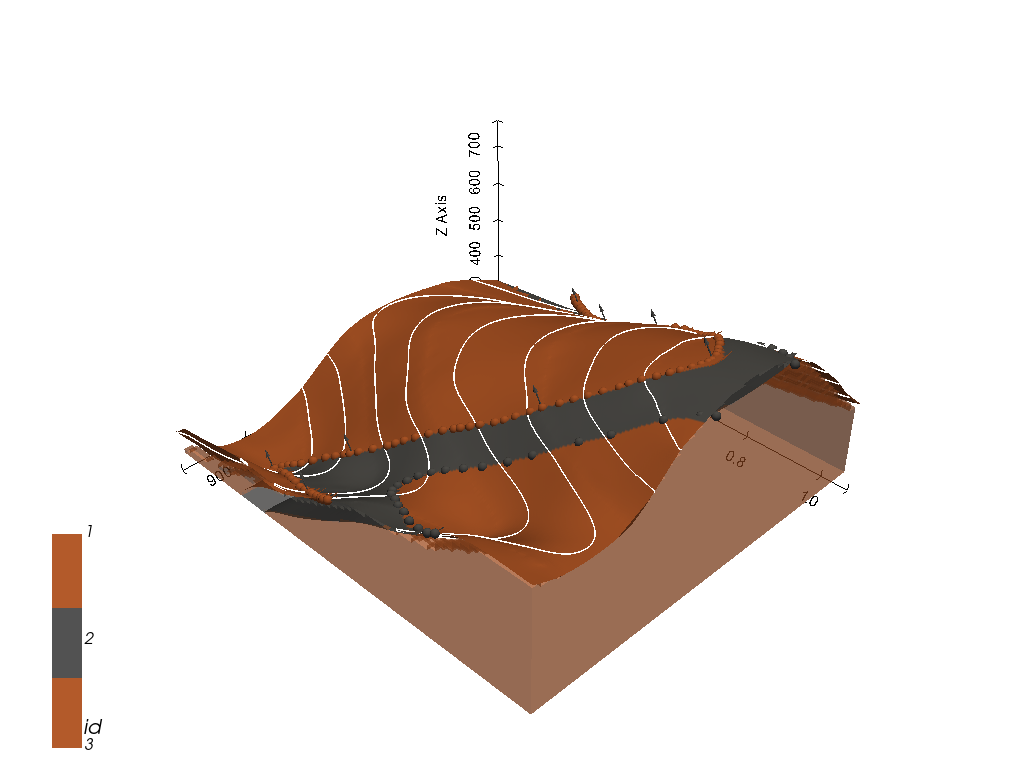

In [11]:
gpv = gp.plot_3d(geo_model, image=False, show_topography=True,
                 plotter_type='basic', notebook=True, show_lith=True)

<a id='borehole'></a>
# Extract borehole from GemPy Model
Geological models are used to extract information from the subsurface. As geologists, we like to look of the result of the model at a single location and down to the maximum z extent in depth. This is termed a borehole or in the case of fluid extraction a well. These boreholes can easily be extracted and displayed using GemGIS. All you need is the `geo_model` object, the `geo_data` object and the location of your borehole, optionally with its maximum depth. 

Active grids: ['regular']
Compiling theano function...
Level of Optimization:  fast_run
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                   values
range              500.2
$C_o$            5957.14
drift equations      [3]
[1. 2. 3.]


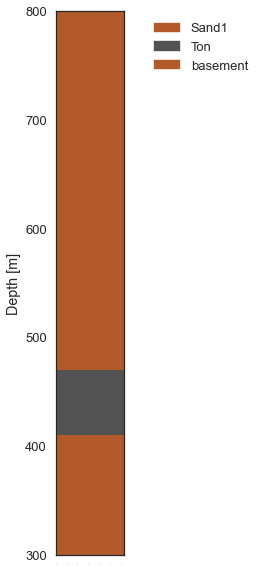

In [12]:
sol = gg.post.extract_borehole(geo_model, geo_data, [500,500])

Active grids: ['regular']
Compiling theano function...
Level of Optimization:  fast_run
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                   values
range              500.2
$C_o$            5957.14
drift equations      [3]
[1. 2.]


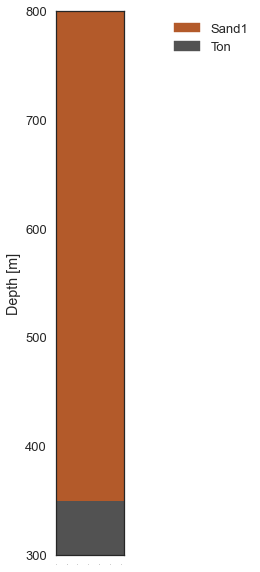

In [13]:
sol = gg.post.extract_borehole(geo_model, geo_data, [250,250])

<a id='map'></a>
# Extracting Depth Maps from GemPy Models
Depth maps indicate the depth of a surface within the model extent. By applying an intuitive color coding, the spatial position of the respective surface can easily be interpreted. Depth maps can easily be created by executing `gg.visualization.plot_depth_map(...)`. All that is needed is the `geo_model` object and the name of the surface to be plotted. Optionally, a range for the colorbar can be provided to make the maps of different surfaces comparable. Otherwise, the min and max values of each surface are taken for the limits of the color bar. By setting `notebook` to `False` an interactive PyVista Window is opened (press 'Q' to close window safely again).

## Depth Map Sand1

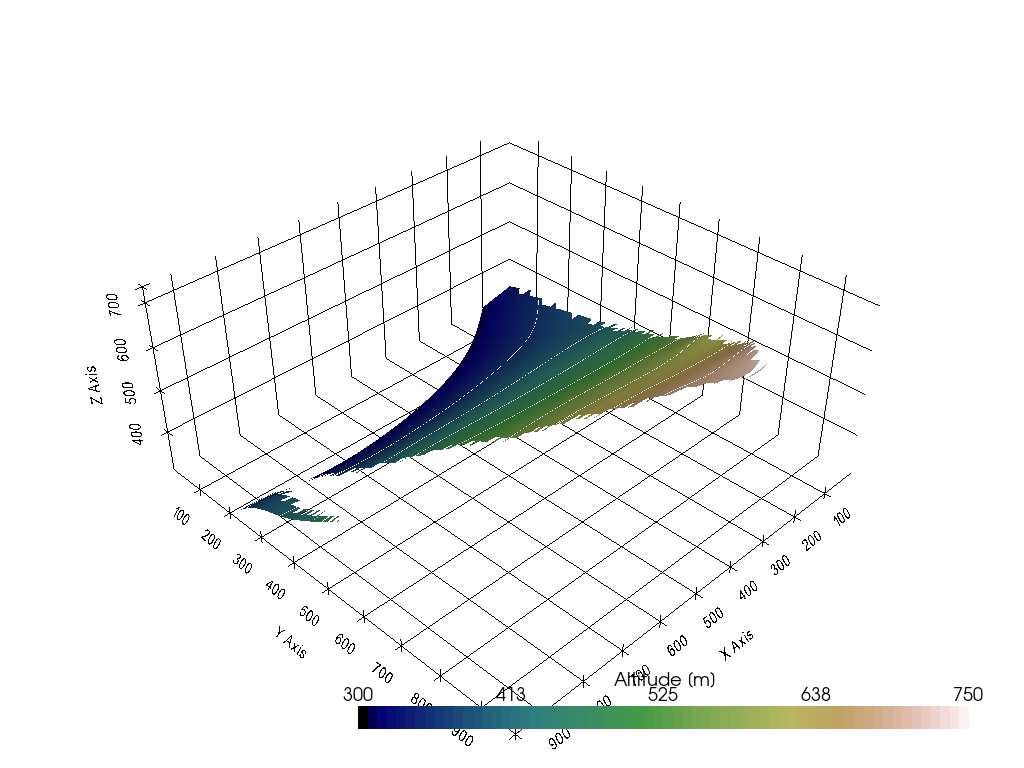

In [14]:
gg.visualization.plot_depth_map(geo_model, 'Sand1', clim=[300, 750], notebook=True)

## Depth Map Ton

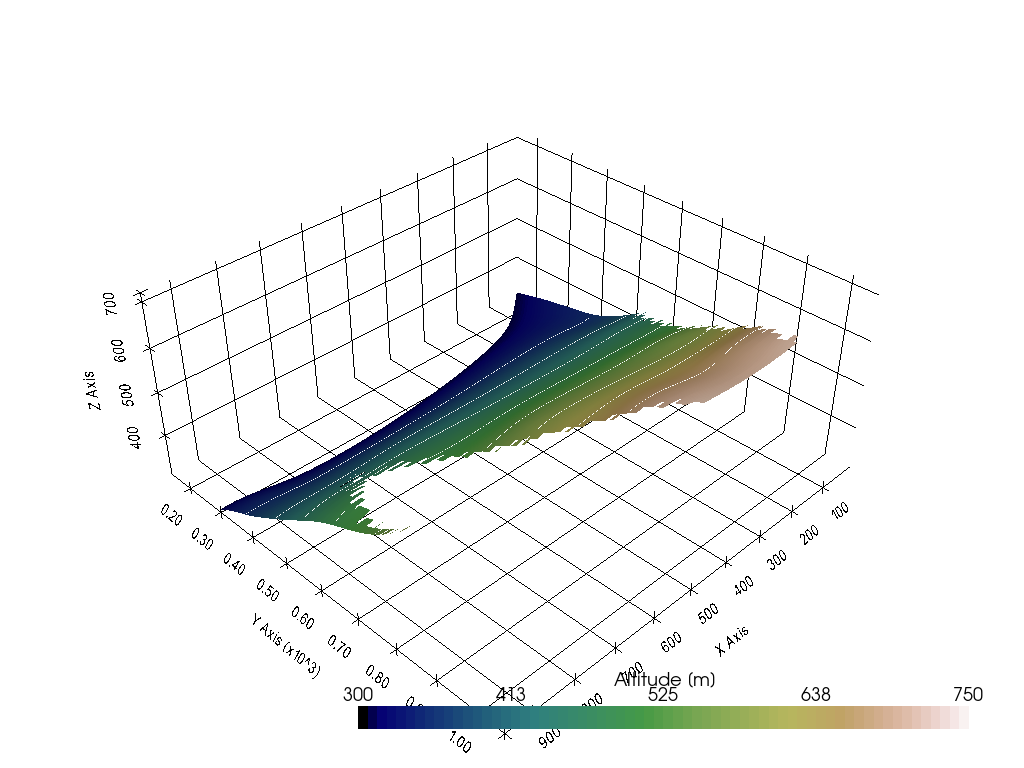

In [15]:
gg.visualization.plot_depth_map(geo_model, 'Ton', clim=[300, 750], notebook=True)